# Sentinel Hub Statistical API

This notebook shows how to use Sentinel Hub Statistical API to obtain aggregated statistical satellite data for areas of interest. For more information about Statistical API in Copernicus Data Space Ecosystem please check the [official service documentation](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html).

## Prerequisites

### Imports

The tutorial requires additional packages `geopandas`, `matplotlib`, and `seaborn` which are not dependencies of `sentinelhub-py`.

In [1]:
%matplotlib inline

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    Geometry,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    SHConfig,
    parse_time,
)

### Credentials

Process API requires Sentinel Hub account. Please check [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html) about how to set up your Sentinel Hub credentials.

In [2]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Statistical API, please provide the credentials (OAuth client ID and client secret).")

### Helper function

A helper function that will be used in this tutorial.

In [3]:
def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

## Make a Statistical API request

In the [Process API tutorial](./process_request_cdse.ipynb), we have seen how to obtain satellite imagery. Statistical API can be used in a very similar way. The main difference is that the results of Statistical API are aggregated statistical values of satellite data instead of entire images. In many use cases, such values are all that we need. By using Statistical API we can avoid downloading and processing large amounts of satellite data.

Let's take the same bounding box of Betsiboka Estuary, used in Process API tutorial, and make a Statistical API request.

In [4]:
betsiboka_bbox = BBox((46.16, -16.15, 46.51, -15.58), CRS.WGS84)

rgb_evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "B02",
          "B03",
          "B04",
          "dataMask"
        ]
      }
    ],
    output: [
      {
        id: "rgb",
        bands: ["R", "G", "B"]
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}

function evaluatePixel(samples) {
    return {
      rgb: [samples.B04, samples.B03, samples.B02],
      dataMask: [samples.dataMask]
    };
}
"""

rgb_request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=rgb_evalscript,
        time_interval=("2020-06-07", "2020-06-13"),
        aggregation_interval="P1D",
        size=(631, 1047),
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L1C.define_from("s2l1c", service_url=config.sh_base_url), maxcc=0.8
        )
    ],
    bbox=betsiboka_bbox,
    config=config,
)

The following will send the request to Sentinel Hub service and obtain results.

In [5]:
%%time

rgb_stats = rgb_request.get_data()[0]

rgb_stats

CPU times: user 44.7 ms, sys: 8.14 ms, total: 52.8 ms
Wall time: 2.63 s


{'data': [{'interval': {'from': '2020-06-07T00:00:00Z',
    'to': '2020-06-08T00:00:00Z'},
   'outputs': {'rgb': {'bands': {'R': {'stats': {'min': 0.005200000014156103,
        'max': 0.7318000197410583,
        'mean': 0.11242533889048499,
        'stDev': 0.04222714997665462,
        'sampleCount': 660657,
        'noDataCount': 0}},
      'G': {'stats': {'min': 0.023399999365210533,
        'max': 0.6244999766349792,
        'mean': 0.09885180313168461,
        'stDev': 0.019808173147670315,
        'sampleCount': 660657,
        'noDataCount': 0}},
      'B': {'stats': {'min': 0.04839999973773956,
        'max': 0.5511999726295471,
        'mean': 0.10197930391648807,
        'stDev': 0.014945352835537199,
        'sampleCount': 660657,
        'noDataCount': 0}}}}}},
  {'interval': {'from': '2020-06-12T00:00:00Z', 'to': '2020-06-13T00:00:00Z'},
   'outputs': {'rgb': {'bands': {'R': {'stats': {'min': 0.006899999920278788,
        'max': 0.7473999857902527,
        'mean': 0.1167893

We obtained statistical data for pixels for each band and for both available acquisition dates.

## Multiple requests for a collection of geometries

The real value of Statistical API shows for use cases where we have a large collection of small geometries, sparsely distributed over a large geographical area, and we would like to obtain statistical information for each of them.

In this example, we will take `4` small polygons, each marking a different land cover type, and collect [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) values for each of them.

In [6]:
polygons_gdf = gpd.read_file("data/statapi_test.geojson")

polygons_gdf

,land_type,geometry
0,water,"POLYGON ((411873.909 5126285.627, 412036.018 5..."
1,forest,"POLYGON ((451909.515 5087408.351, 452291.478 5..."
2,agricultural,"POLYGON ((553495.985 5137450.826, 554130.662 5..."
3,urban,"POLYGON ((548010.445 5156156.292, 549867.483 5..."


For each polygon, we define a Statistical API request. Requested statistical data will be calculated on `10`-meter resolution and aggregated per day with an available acquisition. We will also request histogram values.

In [7]:
yearly_time_interval = "2020-01-01", "2020-12-31"

ndvi_evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "B04",
          "B08",
          "dataMask"
        ]
      }
    ],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}

function evaluatePixel(samples) {
    return {
      ndvi: [index(samples.B08, samples.B04)],
      dataMask: [samples.dataMask]
    };
}
"""

aggregation = SentinelHubStatistical.aggregation(
    evalscript=ndvi_evalscript, time_interval=yearly_time_interval, aggregation_interval="P1D", resolution=(10, 10)
)

input_data = SentinelHubStatistical.input_data(
    DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url)
)

histogram_calculations = {"ndvi": {"histograms": {"default": {"nBins": 20, "lowEdge": -1.0, "highEdge": 1.0}}}}

ndvi_requests = []

for geo_shape in polygons_gdf.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(polygons_gdf.crs)),
        calculations=histogram_calculations,
        config=config,
    )
    ndvi_requests.append(request)

Instead of triggering download for each request separately, we can pass request objects together to a download client object, which will execute them in parallel using multiple threads. This way the download process will be faster.

In [8]:
%%time

download_requests = [ndvi_request.download_list[0] for ndvi_request in ndvi_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

ndvi_stats = client.download(download_requests)

len(ndvi_stats)

CPU times: user 151 ms, sys: 17.1 ms, total: 168 ms
Wall time: 4.71 s


4

Let's convert this data into a tabular form by transforming it into a `pandas` dataframe.

In [9]:
ndvi_dfs = [stats_to_df(polygon_stats) for polygon_stats in ndvi_stats]

for df, land_type in zip(ndvi_dfs, polygons_gdf["land_type"].values):
    df["land_type"] = land_type

ndvi_df = pd.concat(ndvi_dfs)

ndvi_df

,interval_from,interval_to,ndvi_B0_min,ndvi_B0_max,ndvi_B0_mean,ndvi_B0_stDev,ndvi_B0_sampleCount,ndvi_B0_noDataCount,land_type
0,2020-01-01,2020-01-02,-0.030612,0.080251,0.040566,0.013618,9174,4322,water
1,2020-01-04,2020-01-05,0.013191,0.115481,0.059611,0.015508,9174,4322,water
2,2020-01-06,2020-01-07,-1.000000,1.000000,-0.335580,0.359610,9174,4322,water
3,2020-01-09,2020-01-10,-1.000000,1.000000,-0.041043,0.496412,9174,4322,water
4,2020-01-11,2020-01-12,-1.000000,1.000000,-0.145741,0.260298,9174,4322,water
...,...,...,...,...,...,...,...,...,...
139,2020-12-18,2020-12-19,-0.056414,0.088782,0.019838,0.015522,43263,11755,urban
140,2020-12-21,2020-12-22,-0.096983,0.071051,0.002479,0.010128,43263,11755,urban
141,2020-12-23,2020-12-24,-0.053071,0.672992,0.204612,0.113249,43263,11755,urban
142,2020-12-26,2020-12-27,-0.177143,1.000000,0.331148,0.199792,43263,11755,urban


The following plot shows time series of mean values, buffered by standard deviation values.

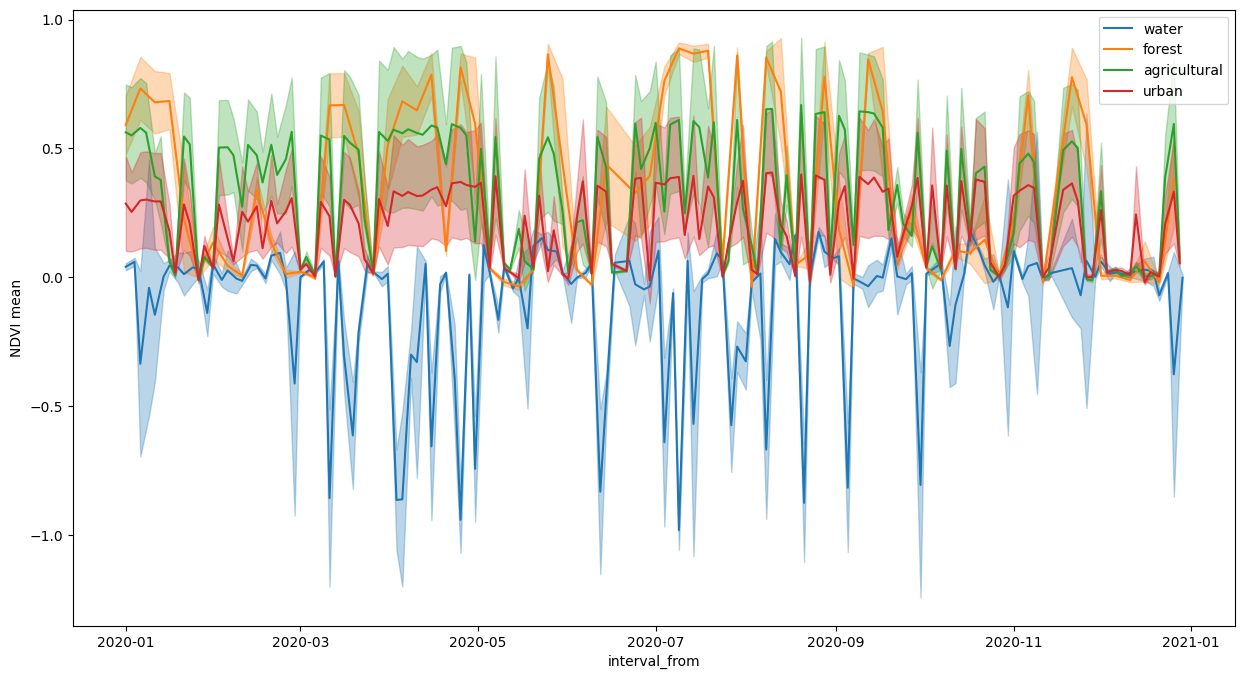

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_ylabel("NDVI mean")

for idx, land_type in enumerate(polygons_gdf["land_type"].values):
    series = ndvi_df[ndvi_df["land_type"] == land_type]

    series.plot(ax=ax, x="interval_from", y="ndvi_B0_mean", color=f"C{idx}", label=land_type)

    ax.fill_between(
        series.interval_from.values,
        series["ndvi_B0_mean"] - series["ndvi_B0_stDev"],
        series["ndvi_B0_mean"] + series["ndvi_B0_stDev"],
        color=f"C{idx}",
        alpha=0.3,
    );

Let's also plot histograms for a certain timestamp.

/var/folders/6d/dhptzxl57h3808971hpq8l480000gn/T/ipykernel_18334/1507715021.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=polygons_gdf["land_type"].values)


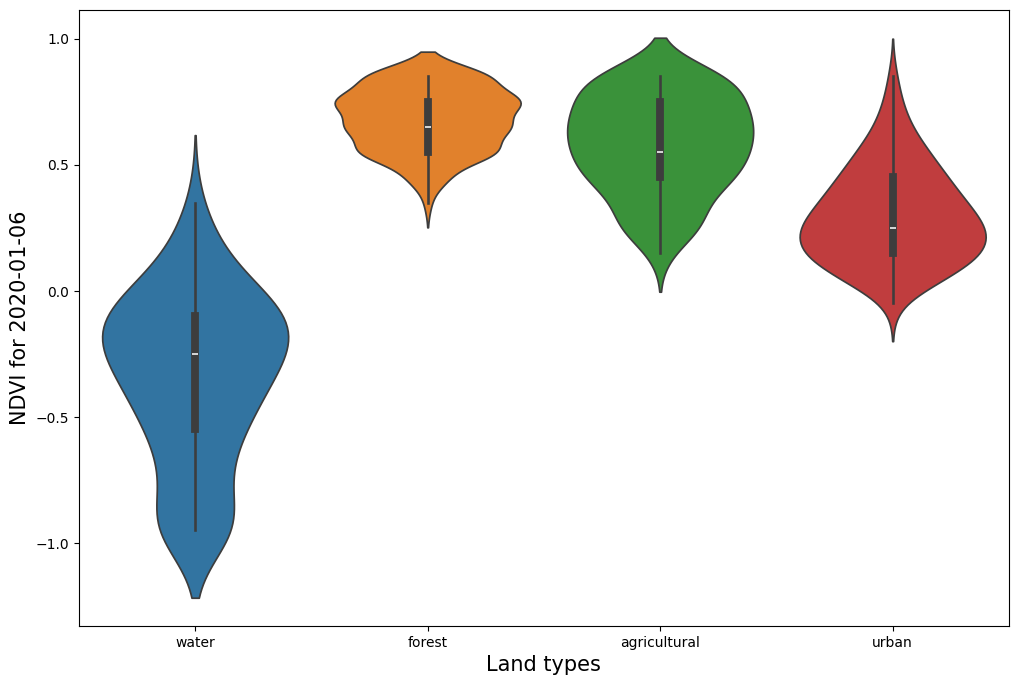

In [11]:
TIMESTAMP_INDEX = 2

plot_data = []
timestamp = None
for stats in ndvi_stats:
    bins = stats["data"][TIMESTAMP_INDEX]["outputs"]["ndvi"]["bands"]["B0"]["histogram"]["bins"]
    timestamp = stats["data"][TIMESTAMP_INDEX]["interval"]["from"].split("T")[0]

    counts = [value["count"] for value in bins]
    total_counts = sum(counts)
    counts = [round(100 * count / total_counts) for count in counts]

    bin_size = bins[1]["lowEdge"] - bins[0]["lowEdge"]
    splits = [value["lowEdge"] + bin_size / 2 for value in bins]

    data = []
    for count, split in zip(counts, splits):
        data.extend([split] * count)
    plot_data.append(np.array(data))


fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.violinplot(data=plot_data, ax=ax)
ax.set(xticklabels=polygons_gdf["land_type"].values)
plt.xlabel("Land types", fontsize=15)
plt.ylabel(f"NDVI for {timestamp}", fontsize=15);

## Reduce service processing costs

In case of large-scale processing, it becomes important, how many processing units we spend making Statistical API requests. We can decrease this number if we write an evalscript that outputs integer values instead of floats.

In this example, we will download statistics for all Sentinel-2 L2A bands, cloud masks and probabilities, and a few remote sensing indices. Such a collection of values would typically be used as an input to a machine learning model.

The following evalscript will:

- request band values in digital numbers, instead of reflectances,
- use `toUINT` function to convert values from indices into integers that will fit into `SampleType.UINT16`,
- mask pixels for which cloud mask `SCL` indicates that they contain clouds. Such pixels will not be included in statistics.

In [12]:
with open("./data/statapi_evalscript_cdse.js", "r") as fp:
    features_evalscript = fp.read()

print(features_evalscript)

//VERSION=3

function setup() {
  return {
    input: [{
      bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "SCL", "dataMask"],
      units: "DN"
    }],
    output: [
      {
        id: "bands",
        bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
        sampleType: "UINT16"
      },
      {
        id: "masks",
        bands: ["SCL"],
        sampleType: "UINT16"
      },
      {
        id: "indices",
        bands: ["NDVI", "NDVI_RE1", "NBSI"],
        sampleType: "UINT16"
      },
      {
        id: "dataMask",
        bands: 1
      }]
  }
}

function evaluatePixel(samples) {
    // Normalised Difference Vegetation Index and variation
    let NDVI = index(samples.B08, samples.B04);
    let NDVI_RE1 = index(samples.B08, samples.B05);

    // Bare Soil Index
    let NBSI = index((samples.B11 + samples.B04), (samples.B08 + samples.B02));

    // masking cloudy pixels
    const clouds = 

Let's create requests for all `4` polygons. Additionally, we will request statistics for `5th`, `50th` and `95th` percentiles.

In [13]:
aggregation = SentinelHubStatistical.aggregation(
    evalscript=features_evalscript, time_interval=yearly_time_interval, aggregation_interval="P1D", resolution=(10, 10)
)

calculations = {"default": {"statistics": {"default": {"percentiles": {"k": [5, 50, 95]}}}}}

features_requests = []
for geo_shape in polygons_gdf.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[
            SentinelHubStatistical.input_data(
                DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url)
            )
        ],
        geometry=Geometry(geo_shape, crs=CRS(polygons_gdf.crs)),
        calculations=calculations,
        config=config,
    )

    features_requests.append(request)

In [14]:
%%time

download_requests = [request.download_list[0] for request in features_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

features_stats = client.download(download_requests)

len(features_stats)

CPU times: user 154 ms, sys: 20.1 ms, total: 174 ms
Wall time: 8.66 s


4

Let's convert service response into a dataframe. Compared to the previous example this dataframe will have more columns, as we requested more types of features, and fewer rows, as in some cases all pixels contained clouds and were masked.

In [15]:
features_dfs = [stats_to_df(polygon_stats) for polygon_stats in features_stats]

for df, land_type in zip(features_dfs, polygons_gdf["land_type"].values):
    df["land_type"] = land_type

features_df = pd.concat(features_dfs)

features_df

,interval_from,interval_to,indices_NDVI_min,indices_NDVI_max,indices_NDVI_mean,indices_NDVI_stDev,indices_NDVI_sampleCount,indices_NDVI_noDataCount,indices_NDVI_percentiles_5.0,indices_NDVI_percentiles_95.0,...,bands_B12_min,bands_B12_max,bands_B12_mean,bands_B12_stDev,bands_B12_sampleCount,bands_B12_noDataCount,bands_B12_percentiles_5.0,bands_B12_percentiles_95.0,bands_B12_percentiles_50.0,land_type
0,2020-01-01,2020-01-02,4847.0,5401.0,5202.713945,67.897677,9174,4563,5083.0,5303.0,...,599.0,6185.0,2294.539146,968.958395,9174,4563,995.0,4008.0,2143.0,water
1,2020-01-06,2020-01-07,0.0,10000.0,3322.093776,1798.047535,9174,4322,0.0,5875.0,...,0.0,101.0,29.380668,15.811909,9174,4322,3.0,56.0,30.0,water
2,2020-01-09,2020-01-10,0.0,10000.0,4794.789984,2482.065488,9174,4322,0.0,10000.0,...,19.0,194.0,57.437552,18.549149,9174,4322,32.0,88.0,55.0,water
3,2020-01-11,2020-01-12,0.0,10000.0,4271.293487,1301.485951,9174,4322,1970.0,6307.0,...,0.0,235.0,25.601195,22.529111,9174,4322,3.0,57.0,21.0,water
4,2020-01-14,2020-01-15,4054.0,6590.0,5021.209292,273.010776,9174,4869,4571.0,5362.0,...,62.0,1737.0,375.703600,372.593280,9174,4869,83.0,1208.0,183.0,water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2020-11-21,2020-11-22,368.0,10000.0,6820.235115,1036.439819,43263,11755,5334.0,8678.0,...,145.0,3820.0,1148.828520,394.078733,43263,11755,605.0,1864.0,1100.0,urban
86,2020-11-23,2020-11-24,4549.0,9493.0,6454.387894,910.613923,43263,21440,5243.0,8131.0,...,336.0,4731.0,1567.396142,470.591109,43263,21440,920.0,2401.0,1511.0,urban
87,2020-12-01,2020-12-02,4303.0,9299.0,6303.657706,871.164237,43263,11755,5141.0,7937.0,...,172.0,4677.0,1152.941602,409.914386,43263,11755,575.0,1886.0,1110.0,urban
88,2020-12-23,2020-12-24,4790.0,5598.0,5163.000000,187.385538,43263,43063,4891.0,5495.0,...,1398.0,3467.0,2115.780000,447.570611,43263,43063,1515.0,2950.0,2041.0,urban


Next, we can rescale values back to the correct scale. The following will:

- convert statistical values for bands from digital numbers to reflectances,
- apply an inverse transformation of `toUINT` function on statistical values for indices.

In [16]:
BANDS = DataCollection.SENTINEL2_L2A.bands
INDICES = ["NDVI", "NDVI_RE1", "NBSI"]
STATISTICAL_QUANTITIES = ["mean", "min", "max", "stDev", "percentiles_5.0", "percentiles_50.0", "percentiles_95.0"]

for band in BANDS:
    for stat in STATISTICAL_QUANTITIES:
        column_name = f"bands_{band.name}_{stat}"
        column = features_df[column_name]

        column = column / 10000.0

        features_df[column_name] = column

for index in INDICES:
    for stat in STATISTICAL_QUANTITIES:
        column_name = f"indices_{index}_{stat}"
        column = features_df[column_name]

        if stat == "stDev":
            column = column / 5000.0
        else:
            column = (column - 5000.0) / 5000.0

        features_df[column_name] = column

features_df

,interval_from,interval_to,indices_NDVI_min,indices_NDVI_max,indices_NDVI_mean,indices_NDVI_stDev,indices_NDVI_sampleCount,indices_NDVI_noDataCount,indices_NDVI_percentiles_5.0,indices_NDVI_percentiles_95.0,...,bands_B12_min,bands_B12_max,bands_B12_mean,bands_B12_stDev,bands_B12_sampleCount,bands_B12_noDataCount,bands_B12_percentiles_5.0,bands_B12_percentiles_95.0,bands_B12_percentiles_50.0,land_type
0,2020-01-01,2020-01-02,-0.0306,0.0802,0.040543,0.013580,9174,4563,0.0166,0.0606,...,0.0599,0.6185,0.229454,0.096896,9174,4563,0.0995,0.4008,0.2143,water
1,2020-01-06,2020-01-07,-1.0000,1.0000,-0.335581,0.359610,9174,4322,-1.0000,0.1750,...,0.0000,0.0101,0.002938,0.001581,9174,4322,0.0003,0.0056,0.0030,water
2,2020-01-09,2020-01-10,-1.0000,1.0000,-0.041042,0.496413,9174,4322,-1.0000,1.0000,...,0.0019,0.0194,0.005744,0.001855,9174,4322,0.0032,0.0088,0.0055,water
3,2020-01-11,2020-01-12,-1.0000,1.0000,-0.145741,0.260297,9174,4322,-0.6060,0.2614,...,0.0000,0.0235,0.002560,0.002253,9174,4322,0.0003,0.0057,0.0021,water
4,2020-01-14,2020-01-15,-0.1892,0.3180,0.004242,0.054602,9174,4869,-0.0858,0.0724,...,0.0062,0.1737,0.037570,0.037259,9174,4869,0.0083,0.1208,0.0183,water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2020-11-21,2020-11-22,-0.9264,1.0000,0.364047,0.207288,43263,11755,0.0668,0.7356,...,0.0145,0.3820,0.114883,0.039408,43263,11755,0.0605,0.1864,0.1100,urban
86,2020-11-23,2020-11-24,-0.0902,0.8986,0.290878,0.182123,43263,21440,0.0486,0.6262,...,0.0336,0.4731,0.156740,0.047059,43263,21440,0.0920,0.2401,0.1511,urban
87,2020-12-01,2020-12-02,-0.1394,0.8598,0.260732,0.174233,43263,11755,0.0282,0.5874,...,0.0172,0.4677,0.115294,0.040991,43263,11755,0.0575,0.1886,0.1110,urban
88,2020-12-23,2020-12-24,-0.0420,0.1196,0.032600,0.037477,43263,43063,-0.0218,0.0990,...,0.1398,0.3467,0.211578,0.044757,43263,43063,0.1515,0.2950,0.2041,urban


Let's plot NDVI time series. The number of irregularities in the series has decreased because we masked out cloudy pixels.

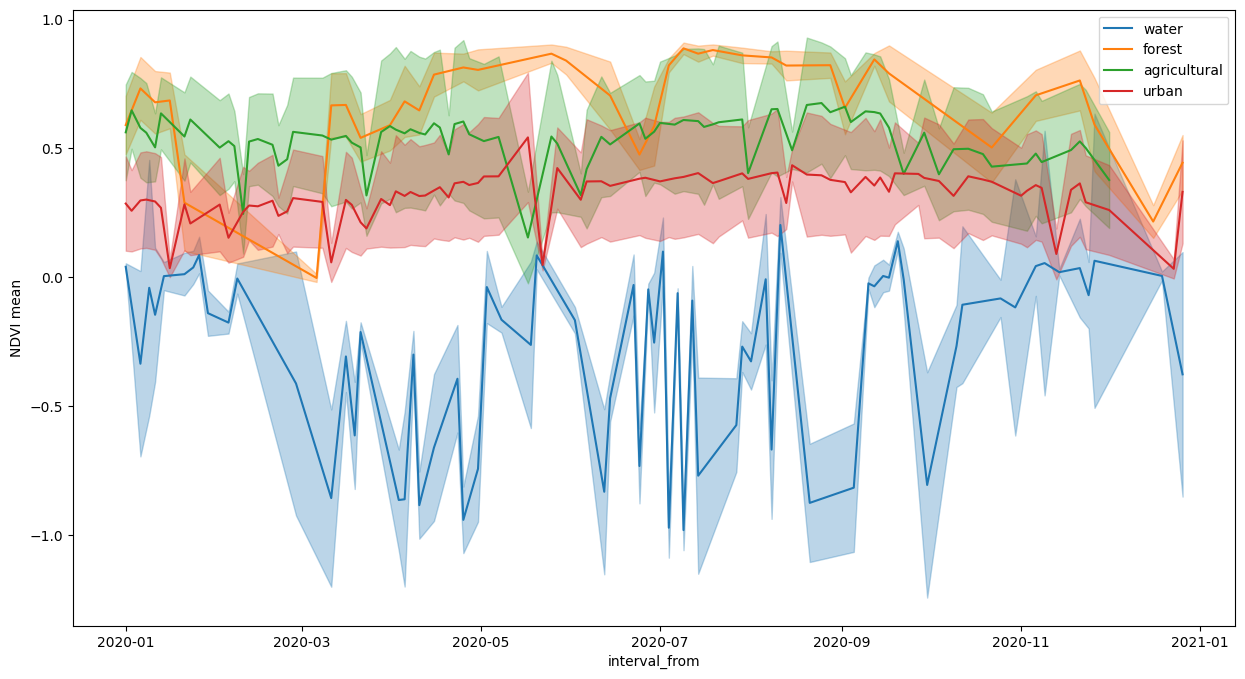

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_ylabel("NDVI mean")

for idx, land_type in enumerate(polygons_gdf["land_type"].values):
    series = features_df[features_df["land_type"] == land_type]

    series.plot(ax=ax, x="interval_from", y="indices_NDVI_mean", color=f"C{idx}", label=land_type)

    ax.fill_between(
        series.interval_from.values,
        series["indices_NDVI_mean"] - series["indices_NDVI_stDev"],
        series["indices_NDVI_mean"] + series["indices_NDVI_stDev"],
        color=f"C{idx}",
        alpha=0.3,
    );